# Q-Learning for FrozenLake-v0

Today I am going to be training a reinforcement learning algorithm to play the FrozenLake-v0 game from Open AI gym. In this game, the agent has to navigate from one corner of a frozen lake to another while avoiding holes in the ice. The catch is that, at every step, the agent has a chance of slipping and taking a random move instead of the one it intended. The lake is described by a 4x4 grid that looks like this.

SFFF       (S: starting point, safe)<br>
FHFH       (F: frozen surface, safe)<br>
FFFH       (H: hole, fall to your doom)<br>
HFFG       (G: goal)<br>

Every turn, the agent can choose from 4 actions: up, down, left, and right. If it ssuccessfully reaches the goal, it gets a reward of 1. Otherwise, it gets nothing.

Since there are a small number of discrete states and options, I will solve this problem with Q-Learning.


<br>Some code adapted from a video by Deep Lizard: https://deeplizard.com/

In [8]:
import gym
import numpy as np
import random

import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
# create environment

env = gym.make('FrozenLake-v0')

## Q-Learning

These parameters contol how the agent will learn. Q-learning works by creating a table of states and actions, and estimating the agents return in each state given that it takes a certain action. It does this by running a series of "episodes" in which the agent plays the game from start to finish.

At each step, the agent will roll a die to determine whether it will explore or exploit. With probability determined by the exploration rate, it will explore, choosing a random action. Otherwise, it will exploit, or look in the Q-table to see what the action with the highest expected return is, given the current state, and take that action. The exxploration rate decays exponentially over time.

Once an agent has taken its action, it will check what its new reward is. Then, it will update the Q-table entry for the action it just took in the state it just left. To do this, it will take a weighted average of the old entry and the new reward adjusted by the discount factor. The weight of the adjusted new reward is determined by the learning rate.

In [41]:
# parameters

num_episodes = 5000 # number of training episodes
max_steps_per_episode = 100 # to prevent infinite looping

learning_rate = 0.05
discount_rate = 0.99 # discount rate of future rewards

exploration_rate = 1
exploration_decay_rate = 0.99995 # very sensitive

In [42]:
# NOTE: rerunning this block without the previous block will not work

q_table = np.zeros((env.observation_space.n, env.action_space.n))

# these keep track of important variables so we can visualize them later
rewards_all_episodes = []
exploration_rates_all_episodes = []

# training loop
for episode in range(num_episodes):
    state = env.reset()
    
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        if exploration_rate <= random.random(): # should we explore?
            action = np.argmax(q_table[state, :]) # 'best' action
        else:
            action = env.action_space.sample() # random action
            
        new_state, reward, done, info = env.step(action)
        
        # update Q-table
        new_value = (reward + discount_rate * np.max(q_table[new_state, :]))
        old_value = q_table[state, action]
        q_table[state, action] =  learning_rate * new_value + (1 - learning_rate) * old_value
        
        # book keeping
        
        state = new_state
        rewards_current_episode += reward
        
        if done == True:
            break
        
        exploration_rates_all_episodes.append(exploration_rate)
        exploration_rate *= exploration_decay_rate
    
    rewards_all_episodes.append(rewards_current_episode)
    
print("Final Score Estimate:", np.mean(rewards_all_episodes[-100:]), "\n")
print("Final Q-Table")
print(q_table)

Final Score Estimate: 0.69 

Final Q-Table
[[0.54458123 0.48906867 0.48283597 0.48312151]
 [0.25770172 0.23788875 0.21547457 0.42472991]
 [0.36532346 0.22853778 0.16483074 0.22527971]
 [0.13039151 0.0139441  0.01349325 0.02055888]
 [0.55954161 0.24072092 0.38712494 0.35056715]
 [0.         0.         0.         0.        ]
 [0.17991159 0.09895159 0.30888191 0.05480139]
 [0.         0.         0.         0.        ]
 [0.38335142 0.3807115  0.4199916  0.58827858]
 [0.47261908 0.6189075  0.54683084 0.41772752]
 [0.61001157 0.36233617 0.37928827 0.31037065]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.48352512 0.53763732 0.71581778 0.50603326]
 [0.67260727 0.88017488 0.77734706 0.78736147]
 [0.         0.         0.         0.        ]]


## Results

As you can see, as the agent learns the game, its abilty increases rapidly until it wins about 70% of the time. This might not seem like a great number, but recall that, even with perfect play, there is a chance that it will slip each turn, which often means falling into a hole. In fact, even with much longer training periods and different paramter values, the agent seems to win between 70% and 80% of the time.

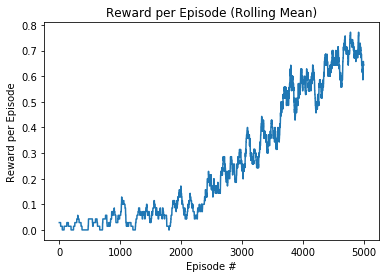

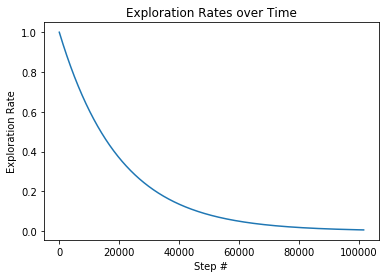

In [33]:
# create summary visualizations

# sqrt(num_episodes) seems to be a good rolling mean size
plt.plot(uniform_filter(rewards_all_episodes, size=num_episodes**0.5))
plt.title("Reward per Episode (Rolling Mean)")
plt.xlabel('Episode #')
plt.ylabel('Reward per Episode')
plt.show()

plt.plot(exploration_rates_all_episodes)
plt.title("Exploration Rates over Time")
plt.xlabel('Step #')
plt.ylabel('Exploration Rate')
plt.show()

Note that the x-axes on the two charts are different. So, although they are almost comparable, some episodes take more steps than others, and the correspondance is not 1:1.